## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

import sys
sys.path.append('hifigan/')
import numpy as np
import torch
import librosa
import librosa.display
import math
import json
import os

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence, symbol_to_id
from text.cleaners import transliteration_ua_cleaners, english_cleaners, transliteration_cleaners,transliteration_cleaners_with_stress
from text.rudict import RuDict

from torch.nn import functional as F

from sklearn.metrics.pairwise import cosine_similarity as cs


from hifigan.meldataset import MAX_WAV_VALUE
from hifigan.models import Generator
from hifigan.env import AttrDict

from audio_processing import get_mel

loaded = False



In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')
    plt.savefig('out.png')
    ipd.display(ipd.Image('out.png'))

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050
hparams.end_symbols_ids = [symbol_to_id[s] for s in '?!.']
# hparams.use_gst = False

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
checkpoint_path = "checkpoint_39500"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [5]:
ref_mel = get_mel('test/test41.wav', hparams).type(torch.HalfTensor).cuda()
print(ref_mel.dtype, ref_mel.shape)

torch.float16 torch.Size([1, 80, 650])


In [6]:

text = "Тетрагидропиранилциклопентилтетрагидропиридопиридиновые вещества".lower()
text = "Мин+истр здравоохран+ения улет+ел. И обещ+ал верн+уться. С вакц+инами. Нав+ерно, +есть как+ой-то м+ир, где мин+истрам л+ично н+адо лет+ать за вакц+инами с четырьм+я перес+адками во вр+емя эпид+емии. М+ожет по+этому в Зимб+абве уже вакцин+ируют, потом+у чт+о их мин+истр л+ично с+ел на слон+а и по+ехал на нем в больш+ой г+ород преклон+ить кол+ено и получ+ить вакц+ину? Так+ой м+ир нам пыт+аются прод+ать?".lower()
# text = "Вс+е смеш+алось в д+оме Обл+онских. Жен+а узн+ала, что муж был в св+язи с б+ывшею в их д+оме франц+уженкою-гуверн+анткой, и объяв+ила м+ужу, что не м+ожет ж+ить с ним в одн+ом д+оме. Полож+ение это продолж+алось уже третий д+ень и муч+ительно ч+увствовалось и сам+ими супр+угами, и вс+еми чл+енами семь+и, и домоч+адцами."
# text = "Тв+орог или твор+ог, к+озлы или козл+ы, з+амок или зам+ок.".lower()
# text="мн+е хот+елось б+ы? сказ+ать к+ак я призн+ателен вс+ем прис+утсвующим сд+есь."
# text = "tak+oi m+ir n+am pyt+aiutsia prod+at'?"
# text = "т+ы сказ+ал? сказ+ал!"
# text = "В+ыйду,,,,,,, н+очью,,, в п+оле,,, с кон+ем"
# text = "Н+очь, +улица, фон+арь, апт+ека. Бессм+ысленный, и т+усклый св+ет. Жив+и ещ+е х+оть ч+етверть в+ека - Вс+ё б+удет т+ак. Исх+ода н+ет."
# text = "Ночь, улица, фонарь, аптека. Бессмысленный, и тусклый свет. Жив+и еще хоть четверть века - Все будет так. Исхода нет."

print(transliteration_cleaners_with_stress(text))
sequence = np.array(text_to_sequence(text, ['transliteration_cleaners']))[None, :]
print(sequence)
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

Smin+istr zdravookhran+eniia ulet+el. i obeshch+al vern+ut'sia. s vakts+inami. nav+erno, +est' kak+oi-to m+ir, gd+e min+istram l+ichno n+ado let+at' z+a vakts+inami s chetyr'm+ia peres+adkami vo vr+emia epid+emii. m+ozhet po+etomu v zimb+abve uzh+e vaktsin+iruiut, potom+u cht+o +ikh min+istr l+ichno s+el n+a slon+a i po+ekhal n+a nem v bol'sh+oi g+orod preklon+it' kol+eno i poluch+it' vakts+inu? tak+oi m+ir n+am pyt+aiutsia prod+at'?E
[[26 22 27 40 22 32 33 31 11 39 17 31 14 35 28 28 24 21 31 14 27 40 18 27
  22 22 14 11 34 25 18 33 40 18 25  7 11 22 11 28 15 18 32 21 16 21 40 14
  25 11 35 18 31 27 40 34 33  3 32 22 14  7 11 32 11 35 14 24 33 32 40 22
  27 14 26 22  7 11 27 14 35 40 18 31 27 28  6 11 40 18 32 33  3 11 24 14
  24 40 28 22  1 33 28 11 26 40 22 31  6 11 20 17 18 11 26 22 27 40 22 32
  33 31 14 26 11 25 40 22 16 21 27 28 11 27 40 14 17 28 11 25 18 33 40 14
  33  3 11 39 14 11 35 14 24 33 32 40 22 27 14 26 22 11 32 11 16 21 18 33
  38 31  3 26 40 22 14 11 29 18 31 18 32 40

In [7]:
%%time
# np.random.seed(16)

_, mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence,seed=None)

tensor(-1.2040e-05, device='cuda:0', dtype=torch.float16,
       grad_fn=<MeanBackward0>)
Warning! Reached max decoder steps
CPU times: user 2.03 s, sys: 316 ms, total: 2.34 s
Wall time: 1.79 s


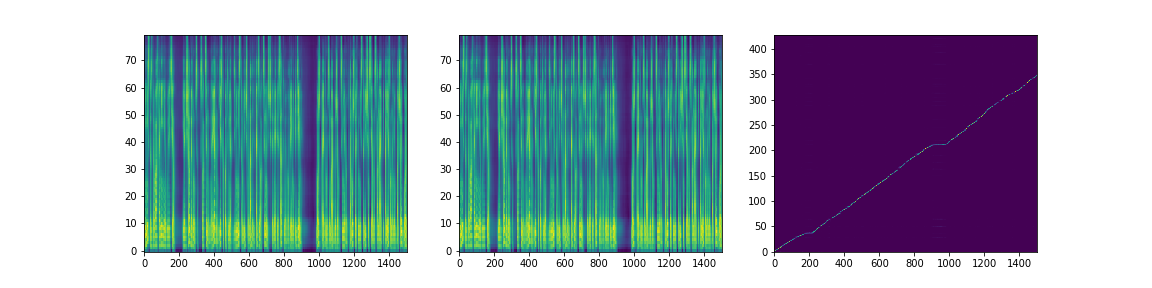

In [8]:
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [9]:
def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

if not loaded:
    device = torch.device('cuda')
    with open('hifigan/config.json') as fp:
        json_config = json.load(fp)
        h = AttrDict(json_config)
    generator = Generator(h).to(device)

    state_dict_g = load_checkpoint("hifigan/g_02500000", device)
    generator.load_state_dict(state_dict_g['generator'])
    generator.eval()
    generator.remove_weight_norm()
    loaded=True

def inference(mel, generator):
    

    
    with torch.no_grad():
        y_g_hat = generator(mel)
        audio = y_g_hat.squeeze()
        audio = audio * MAX_WAV_VALUE
        audio = audio.detach().cpu().numpy()#.astype('int16')

        return audio
    


Loading 'hifigan/g_02500000'
Complete.
Removing weight norm...


In [10]:
%%time
mel = mel_outputs_postnet.type(torch.float32)

audio = inference(mel, generator)
ipd.Audio(audio, rate=hparams.sampling_rate)              

CPU times: user 741 ms, sys: 8.55 ms, total: 749 ms
Wall time: 748 ms


In [11]:
# style vectors similarity
vect = model.gst.stl.embed

In [12]:
norm = F.normalize(vect, dim=1).detach().cpu().numpy()
res =  cs(norm, norm)
res

array([[ 1.        , -0.45405501, -0.25780007,  0.09229381,  0.03113518,
         0.01510026, -0.18829037, -0.20801693,  0.11424713,  0.01950254],
       [-0.45405501,  1.        ,  0.05101533,  0.14946942,  0.0049233 ,
        -0.28612745, -0.20030175, -0.00386134, -0.50164199,  0.12679594],
       [-0.25780007,  0.05101533,  1.        ,  0.02190447, -0.17162481,
        -0.14313176,  0.06999333, -0.14960725, -0.16346657, -0.34347178],
       [ 0.09229381,  0.14946942,  0.02190447,  1.        , -0.21458956,
        -0.02623414, -0.27916378, -0.52708774, -0.26842802, -0.02612832],
       [ 0.03113518,  0.0049233 , -0.17162481, -0.21458956,  1.        ,
        -0.34413854, -0.17819877, -0.11625239,  0.05038834,  0.01352564],
       [ 0.01510026, -0.28612745, -0.14313176, -0.02623414, -0.34413854,
         1.        , -0.09206685,  0.01537334,  0.09387825, -0.27444911],
       [-0.18829037, -0.20030175,  0.06999333, -0.27916378, -0.17819877,
        -0.09206685,  1.        ,  0.07165584